# Climate Metrics from BARRA/BARPA

## BARRA
- project cj37
- /g/data/cj37/BARRA_R/...
- 1990/01-2019/02
- 0.11 by 0.11 degree horizontal resolution
- Lats: 65 S to 19.4 N
- Lons: 65 to 197

## BARPA
- project ia39
- 

In [1]:
## Generic IMPORTS

# for paths appending used to import project modules
import sys 
import os # bones
from glob import glob

## math and holding data
import numpy as np
import pandas as pd
import xarray as xr

## dask for large parraalleellism
import dask

## Iris and simple plots for datasets
import iris
import iris.plot as iplt
import iris.quickplot as qplt

import scipy
import random # for shuffle
import importlib

# check how long stuff takes
import time
# ignore some warnings
import warnings

## plotting modules
import matplotlib.pyplot as plt

# cartopy mapping
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#magic function
%matplotlib inline

## Put us in the right repo for local relative pathing
__repo__="/g/data/en0/jwg574/repos/simple_fire_metric//"
os.chdir(__repo__)
# make sure this repo is in syspath
if __repo__ not in sys.path:
    sys.path.extend([__repo__]) 

## LOCAL MODULES FOR ACCESS-S2 HINDCAST STUFF

## set default figure size (inches)
plt.rc('figure', figsize=(6,4))

In [2]:
## 
dir_BARRA = "/g/data/cj37/BARRA/BARRA_R/v1/analysis/"
dir_BARPA = "/g/data/ia39/australian-climate-service/release/CORDEX-CMIP6/output/AUS-15/BOM/ECMWF-ERA5/evaluation/r1i1p1f1/BOM-BARPA-R/v1/"

## Read BARRA winds
Using xarray since it lets us merge along the time dimension

- winds at 10m 1990-2020 are ~ 42GB
    - Takes infinity minutes
    - Don't know how to control chunking
- just one year (2000) is much more managable
    - ~ 20 seconds to read 1 year of u10m
    - ~ 30 seconds to merge into single cube
- need to use chunking to enable underlying dask magic

### Can we save time by assuming coordinates all match?

- lats/lons should be the same
- time axis and variable(s) will change between files
- 

In [7]:
BARRA_daterange = pd.date_range('1990-01-01','2019-03-01',freq='6H')[:-1]

In [9]:
BARRA_daterange_0600Z = BARRA_daterange[1::4]

In [10]:
BARRA_daterange_0600Z

DatetimeIndex(['1990-01-01 06:00:00', '1990-01-02 06:00:00',
               '1990-01-03 06:00:00', '1990-01-04 06:00:00',
               '1990-01-05 06:00:00', '1990-01-06 06:00:00',
               '1990-01-07 06:00:00', '1990-01-08 06:00:00',
               '1990-01-09 06:00:00', '1990-01-10 06:00:00',
               ...
               '2019-02-19 06:00:00', '2019-02-20 06:00:00',
               '2019-02-21 06:00:00', '2019-02-22 06:00:00',
               '2019-02-23 06:00:00', '2019-02-24 06:00:00',
               '2019-02-25 06:00:00', '2019-02-26 06:00:00',
               '2019-02-27 06:00:00', '2019-02-28 06:00:00'],
              dtype='datetime64[ns]', length=10651, freq='24H')

In [3]:
paths_u10m_0600Z = glob(dir_BARRA+'slv/av_uwnd10m/**/**/*0600Z.nc')
paths_v10m_0600Z = glob(dir_BARRA+'slv/av_vwnd10m/**/**/*0600Z.nc')
paths_10mwinds_0600Z = paths_v10m_0600Z.copy()
paths_10mwinds_0600Z.extend(paths_u10m_0600Z)
paths_10mwinds_0600Z.sort()

In [4]:
len(paths_10mwinds_0600Z)

21302

In [ ]:
%%time
ds_u10m_list = [xr.load_dataset(path) for path in paths_u10m_0600Z]


In [ ]:
%%time
ds_u10m = xr.concat(ds_u10m_list,
                    #combine_attrs='drop_conflicts', 
                    #data_vars='av_uwnd10m',
                    dim='time',
                              )

In [ ]:
ds_u10m

In [168]:
cube_u10m = ds_u10m.av_uwnd10m.to_iris()

In [169]:
cube_u10m

<iris 'Cube' of x_wind / (m s-1) (-- : 31; latitude: 768; longitude: 1200)>

### Subset to Australia

In [42]:
import shapely.geometry as sgeom

import cartopy.io.shapereader as shpreader

shpfilename = shpreader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')

reader = shpreader.Reader(shpfilename)
countries = list(reader.records())


Aus, = [country for country in countries if country.attributes['NAME'] == 'Australia']
Aus_geom = Aus.geometry
print(Aus_geom.bounds)

(112.91944420700008, -54.75042083099993, 159.1064559250001, -9.240166924999926)


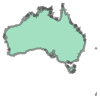

In [44]:
Aus_geom

## Example reading a couple cubes directly

In [16]:
# iris.Future.datum_support=True ## don't know how to get rid of warning
# load in 'cubelist'
dewpt_scrn_sample = iris.load(dir_BARRA+'slv/dewpt_scrn/2018/11/dewpt_scrn-an-slv-PT0H-BARRA_R-v1-20181101T1200Z.nc')
hus_sample = iris.load(dir_BARPA+'day/huss/huss_AUS-15_ECMWF-ERA5_evaluation_r1i1p1f1_BOM-BARPA-R_v1_day_201801-201812.nc')

/jobfs/96252757.gadi-pbs/ipykernel_706205/4245624234.py:3: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  dewpt_scrn_sample = iris.load(dir_BARRA+'slv/dewpt_scrn/2018/11/dewpt_scrn-an-slv-PT0H-BARRA_R-v1-20181101T1200Z.nc')


In [17]:
print(dewpt_scrn_sample)
print(hus_sample)

0: dew_point_temperature / (K)         (latitude: 768; longitude: 1200)
0: specific_humidity / (1)             (time: 365; latitude: 436; longitude: 777)


In [22]:
#select time from hus cube
hus_sample[0][304].coord('time')

<DimCoord: time / (days since 1949-12-01)  [2018-11-01 12:00:00]+bounds>

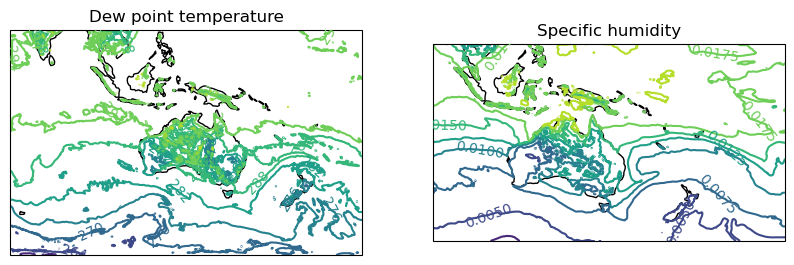

In [26]:

proj = ccrs.PlateCarree(central_longitude=-180.0)

fig = plt.figure(figsize=[10,5])
ax1= plt.subplot(121, projection=proj)
# plot the cube(first cube in cubelist)
contour = qplt.contour(dewpt_scrn_sample[0])
ax1.coastlines()
plt.clabel(contour,inline=False)

ax2 = plt.subplot(122, projection=proj)
contour2 = qplt.contour(hus_sample[0][304])
ax2.coastlines()
plt.clabel(contour2,inline=False)

plt.show()